In [78]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 8*x**2 - x + 9

In [4]:
f(2.0)

39.0

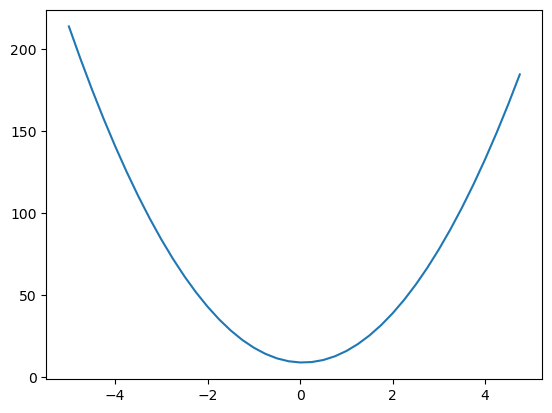

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.001
x = -3.0
(f(x+h) - f(x))/h

-48.99199999999837

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c

In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [62]:
class Value:
    
      
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
            
        return out
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}') 
        
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other ** -1
    
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out       
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) /(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [64]:
a = Value(1.0)
b = Value(2.0)
b-a


Value(data=1.0)

In [12]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s  | data %.4f | grad %.4f}" %(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
        
        

In [65]:
#Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#Bias
b = Value(6.8813735870195432, label='b')
#x1w1 +x2w2 +b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' 
o.backward()

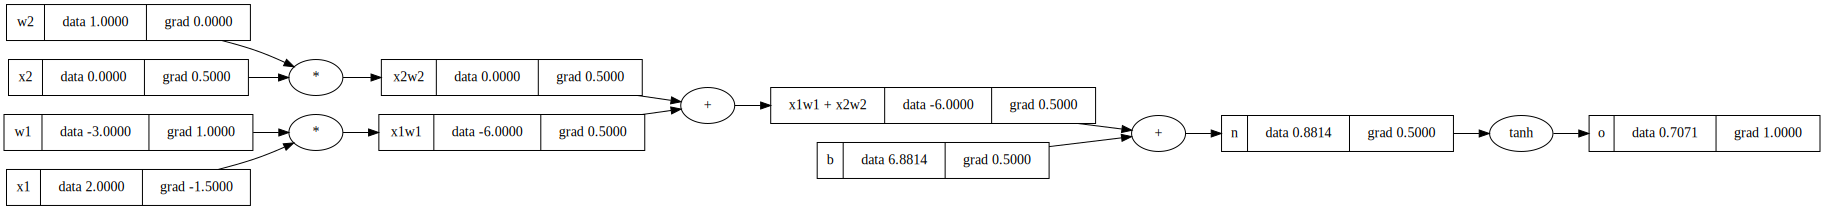

In [68]:
draw_dot(o)

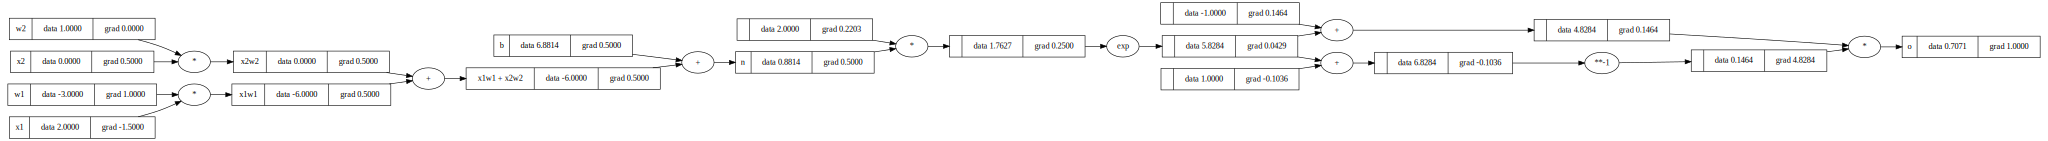

In [70]:
#Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#Bias
b = Value(6.8813735870195432, label='b')
#x1w1 +x2w2 +b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#---
e = (2*n).exp()
o = (e-1) / (e+1); o.label='o'
o.backward()
draw_dot(o)

In [72]:
import torch

In [75]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('-----------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
-----------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [99]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self,nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [206]:
x= [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.8021188269055021)

In [207]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    ]
ys = [1.0, -1.0, -1.0, 1.0]



In [210]:
for k in range(30):
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -0.05 *p.grad
    print(k, loss.data)
    

0 0.021814854728746808
1 0.020852926750158516
2 0.019968199337304322
3 0.01915191761279982
4 0.018396587536973433
5 0.017695758514975984
6 0.017043849238173876
7 0.01643600709272436
8 0.01586799385370389
9 0.015336092128090027
10 0.014837028299398584
11 0.014367908688892022
12 0.013926166372611466
13 0.013509516643442673
14 0.013115919528331067
15 0.012743548095330601
16 0.012390761537246265
17 0.01205608221572228
18 0.01173817600472379
19 0.01143583539515008
20 0.011147964920090216
21 0.01087356853852129
22 0.010611738678258285
23 0.010361646689937639
24 0.010122534505243953
25 0.009893707326416519
26 0.009674527201814068
27 0.009464407365159782
28 0.009262807234980472
29 0.00906922798643035


In [209]:
ypred

[Value(data=0.9743829936490841),
 Value(data=-0.9600766730482018),
 Value(data=-0.8834610764133997),
 Value(data=0.916137917868399)]